# Star finder

* package를 쉽게 설치하기 위해 Anaconda 사용을 권장한다.

경기과학고등학교 관측천문학 강좌를 위해 만들었으며  <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">크리에이티브 커먼즈 저작자표시-비영리-동일조건변경허락 4.0 국제 라이선스</a>에 따라 이용할 수 있음.

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="크리에이티브 커먼즈 라이선스" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a>



먼저 전처리된 fits file을 display 해 보자.


In [1]:
#%%
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.io import fits
#%%
dir_name = '20170220_m35/'
f_name = 'g3035794_p.fits'

hdu = fits.open(dir_name+f_name)
img = hdu[0].data

plt.figure(figsize=(12,12))
ax = plt.gca()
im = plt.imshow(img, vmax=65536, origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

DELMAG   =   0.0000            /Veriable - Comparison,   Delmag                  [astropy.io.fits.card]


<Figure size 1200x1200 with 2 Axes>

별이 많이 보이는 부분만 잘라서 display 해 보자.

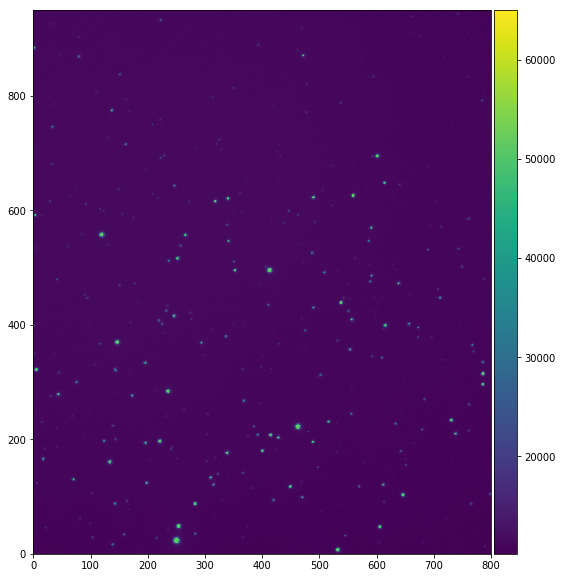

In [2]:
img = hdu[0].data[250:1200, 1000:1800]
plt.figure(figsize=(10,10))
ax = plt.gca()
im = plt.imshow(img, vmax=65000, origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

Maxim DL 을 이용하여 FWHM 을 구해보니 약 2.5 pixels 였다. 

[MAD method](http://docs.astropy.org/en/stable/api/astropy.stats.mad_std.html)를 이용하여 detection threshold 값을 정해보자.

또한 simga-clip (3-sigma, 5 iters)의 방법으로 계산해 보자.

In [3]:
from astropy.stats import mad_std, sigma_clipped_stats

FWHM   = 2.5
sky_th = 5    # sky_th * sky_sigma will be used for detection lower limit
sky_s  = mad_std(img)
thresh = sky_th*sky_s
print(' sky_s x sky_th = threshold')
print('{0:8.6f} x {1:4d}   =   {2:8.6f}\n'.format(sky_s, sky_th, thresh))

# What if we do "sigma-clip" than MAD?
sky_a, sky_m, sky_s_sc = sigma_clipped_stats(img) # default is 3-sigma, 5 iters
thresh_sc = sky_th*sky_s_sc
print('3 sigma 5 iters clipped case:')
print('{0:8.6f} x {1:4d}   =   {2:8.6f}\n'.format(sky_s_sc, sky_th, thresh_sc))


 sky_s x sky_th = threshold
348.411521 x    5   =   1742.057607

3 sigma 5 iters clipped case:
5693.599096 x    5   =   28467.995482



# DAOStarFinder

이제 fits file에서 starfinding 을 해 보자. 

DAOStarFinder에 대한 내용은 [photutils documentation](https://photutils.readthedocs.io/en/stable/api/photutils.DAOStarFinder.html#photutils.DAOStarFinder)에 잘 요약되어 있으므로 이를 참고한다. 

sharpness 와 roundness parameters 에 대한 정보는  [source code](https://photutils.readthedocs.io/en/stable/_modules/photutils/detection/findstars.html)를 참고한다.

`DAOFIND`의 `GROUND` parameter인 `g_roundness` or `roundness1`를 찾고, `DAOFIND`의 `SROUND` 를 위해 `roundness1`를 찾는다.


C:\Users\user\Anaconda3\lib\site-packages\photutils\detection\findstars.py:274: RuntimeWarning: overflow encountered in ulong_scalars
  sum2 = -quad1.sum() + quad2.sum() - quad3.sum() + quad4.sum()


found  id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 400.15607361296156 ... 14.848212819075341 -2.9291854591292643
  2 317.93856704457573 ...  15.06125108047107 -2.9446526213579034
apert Aperture: CircularAperture
positions: [[400.15607361, 317.93856704],
            [180.20468795, 615.67729319]]
r: 4.0


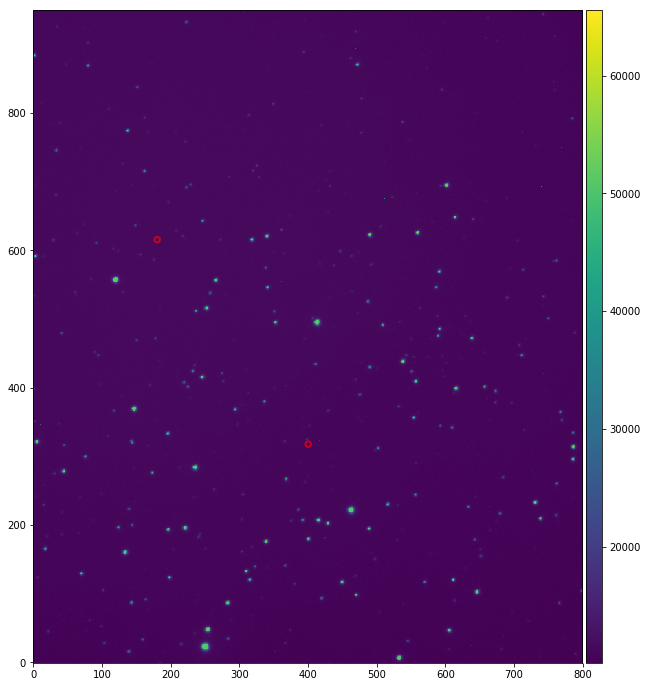

In [4]:
#%%
import numpy as np
import matplotlib.pyplot as plt
from photutils import DAOStarFinder
from photutils import CircularAperture as CircAp

find = DAOStarFinder(fwhm=FWHM, threshold=thresh,
                      sharplo=0.2, sharphi=1.0,  # default values: sharplo=0.2, sharphi=1.0,
                      roundlo=-1.0, roundhi=1.0, # default values: roundlo=-1.0, roundhi=1.0,
                      sigma_radius=1.5,          # default values: sigma_radius=1.5,
                      ratio=1.0,                 # 1.0: circular gaussian:  ratio=1.0,
                      exclude_border=True)       # To exclude sources near edges : exclude_border=True

# The DAOStarFinder object ("find") gets at least one input: the image.
# Then it returns the astropy table which contains the aperture photometry results:
found = find(img)
print('found', found)

# Use the object "found" for aperture photometry:
# save XY coordinates:
coord = (found['xcentroid'], found['ycentroid']) 

# Save apertures as circular, 4 pixel radius, at each (X, Y)
apert = CircAp(coord, r=4.)  
print('apert', apert)

#%%
plt.figure(figsize=(12,12))
ax = plt.gca()
im = plt.imshow(img, vmax=65536, origin='lower')
apert.plot(color='red', lw=2., alpha=0.7)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.show()

이제 감지 된 별들의 X, Y coordinate를 얻을 수 있다. astropy table object가 익숙하지 않은 경우에는 

>imgXY = np.array(coord)

numpy 형식으로 coordinate를 저장할 수 있고, 저장한 coordinate 는 후에 apature photometry toutine에 사용할 수 있다. 

In [5]:
imgXY = np.array(coord)
print('imgXY', imgXY)

imgXY [[400.15607361 317.93856704]
 [180.20468795 615.67729319]]


# IRAFStarFinder

또다른 starfinder인 IRAFStarFinder로 별이 더 잘 찾아질 수도 있다. 

이에 대한 자세한 내용 역시 [photutils documentation](https://photutils.readthedocs.io/en/stable/api/photutils.IRAFStarFinder.html#photutils.IRAFStarFinder)에 잘 요약되어 있으므로 이를 참고한다. 


IRAFfound 
  id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  22.28454274353877 ...             1006.0  -7.506494951799771
  2  405.5223245924876 ...  705.4999999999945 -7.1212425452259085
  3  327.5408970976253 ...              379.0   -6.44659802492018
  4  335.9007616487455 ...             1116.0  -7.619160486503899
  5  18.30100043497173 ...  766.3333333333267  -7.211044291374033
  6  553.8010471204188 ...  413.8333333333376  -6.542063672927313
  7 126.61483175432865 ...  255.0833333333303  -6.016705208874261
  8   634.788823911631 ...              769.5  -7.215521560418744
  9  658.8925978312117 ...  883.7500000000055  -7.365823567012396
 10 356.03034166241713 ... 1307.3333333333394  -7.790965836530263
...                ... ...                ...                 ...
342 258.73220802919707 ...              548.0 -6.8469513962109225
343 425.29300935550935 ...  641.3333333333285  -7.01770953245532

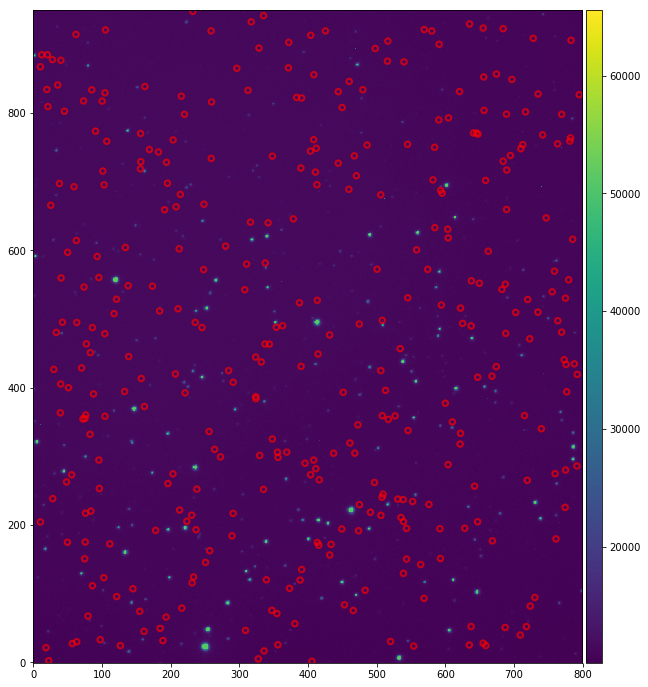

In [6]:
#%%
import numpy as np
import matplotlib.pyplot as plt
from photutils import IRAFStarFinder
from photutils import CircularAperture as CircAp

IRAFfind = IRAFStarFinder(fwhm=FWHM, threshold=thresh,
                          sigma_radius=1.5, minsep_fwhm=6.5,  # default values: sigma_radius=1.5, minsep_fwhm=2.5,
                          sharplo=0.5, sharphi=2.0,   # default values: sharplo=0.5, sharphi=2.0,
                          roundlo=0.0, roundhi=0.2,   # default values: roundlo=0.0, roundhi=0.2,
                          sky=None, exclude_border=False)  # default values: sky=None, exclude_border=False)

# The DAOStarFinder object ("find") gets at least one input: the image.
# Then it returns the astropy table which contains the aperture photometry results:
IRAFfound = IRAFfind(img)
print('IRAFfound \n', IRAFfound)

if len(IRAFfound)==0 :
    print ('No star founded using IRAFStarFinder')
else : 
    # Use the object "found" for aperture photometry:
    # save XY coordinates:
    print (len(IRAFfound), 'stars founded')
    IRAFcoord = (IRAFfound['xcentroid'], IRAFfound['ycentroid']) 
    
    # Save apertures as circular, 4 pixel radius, at each (X, Y)
    IRAFapert = CircAp(IRAFcoord, r=4.)  
    #print('IRAFapert\n ', IRAFapert)
    
    IRAFimgXY = np.array(IRAFcoord)
    #print('IRAFimgXY \n', IRAFimgXY)

    plt.figure(figsize=(12,12))
    ax = plt.gca()
    im = plt.imshow(img, vmax=65536, origin='lower')
    IRAFapert.plot(color='red', lw=2., alpha=0.7)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.05)
    plt.colorbar(im, cax=cax)
    
    plt.show()